In [3]:
%pylab
%matplotlib inline
import healpy as hp
import time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
from astropy.coordinates import AltAz
from astropy.time import TimeDelta
from astropy.coordinates import get_sun
from functools import reduce
import pandas as pd

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


### Frequency extrapolation

In [4]:
path_SA='/Users/michellemora/Documents/Universidad/10/Seminario/Resultados_SinAlas/'
path_CA='/Users/michellemora/Documents/Universidad/10/Seminario/Resultados_ConAlas/'
path_I='/Users/michellemora/Documents/Universidad/10/Seminario/Resultados_Inicial/'
path_E='/Users/michellemora/Documents/Universidad/10/Seminario/Gain_EDGES/'

In [5]:
T_Hmap = hp.read_map("lambda_haslam408_dsds.fits")  

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/michellemora/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:371: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


Temperature spectral index
    
$$\alpha=-\frac{log(T_1/T_2)}{log(\nu_1/\nu_2)}$$

In [6]:
def T_freq(alpha,freq1,freq2,T1):
    return T1*10**(alpha*log10(freq1/freq2))

### Galactic longitude (l) and latitude (b)

In [7]:
nside = hp.get_nside(T_Hmap)  #nside
npix = hp.nside2npix(nside)   #number of pixels

l, b = hp.pix2ang(nside, arange(npix), lonlat=True)   #(l, b) coordinates for each pixel
g_coord=SkyCoord(l*u.deg, b*u.deg, frame='galactic')  

### Time and location for horizontal coordinates 

In [8]:
Alma_loc = EarthLocation.of_site('ALMA')
start_t=Time('2021-06-14T00:00:00',format='isot')

times6=start_t + TimeDelta(6*60, format='sec')*linspace(0,240,240) #dt=6 min

altaz6 = AltAz(location=Alma_loc, obstime=times6)

### Dynamic Spectra

Temperature matrix for the dynamic spectra

$$T(\nu,t)=\begin{pmatrix}
T(\nu_1,t_m) & T(\nu_2,t_m) & \cdots & T(\nu_n,t_m)\\ 
 \vdots &  \vdots  &\vdots & \vdots  \\ 
T(\nu_1,t_1) & T(\nu_2,t_1) & \cdots & T(\nu_n,t_1)
\end{pmatrix}$$

### Antenna gain files

$$g_{\nu}=g_{\nu}(\theta,\phi)$$

$$g_{\nu}(\theta,\phi)=\begin{pmatrix}
g_{\nu}(\theta=0,\phi=0) & g_{\nu}(\theta=0,\phi=1) & \cdots & g_{\nu}(\theta=0,\phi=359)\\ 
g_{\nu}(\theta=1,\phi=0) & g_{\nu}(\theta=1,\phi=1) & \cdots & g_{\nu}(\theta=1,\phi=359)\\
 \vdots &  \vdots  &\vdots & \vdots  \\ 
g_{\nu}(\theta=90,\phi=0) & g_{\nu}(\theta=90,\phi=1) & \cdots & g_{\nu}(\theta=90,\phi=359)\\
\end{pmatrix}$$

In [9]:
f=arange(40,201,1)
cols=arange(1,361,1)

### $G[\nu,\theta,\phi]$ Matrix

In [17]:
#Sort files in right order

#for i in range (0,len(f)):
#    file='{}{}{}{}'.format(path_E,'Gain_phi_theta_', f[i], "MHz.csv")
#    x=loadtxt(file, skiprows=1,delimiter=',')   #Theta[0:]
#    #new=concatenate((x[:91,181:],x[:91,2:181]),axis=1)       ###Theta[0,90],phi[0,359]
#    savetxt('{}{}{}.txt'.format(path_E,'Gain_E_',f[i]), x[:,1:361])

OSError: /Users/michellemora/Documents/Universidad/10/Seminario/Gain_EDGES/Gain_phi_theta_121MHz.csv not found.

In [22]:
def G_matrix(path,name,size):

    G_FTP=empty((size,91,360))

    for i in range (size):
        file='{}{}{}{}'.format(path,name, f[i], ".txt")
        x=loadtxt(file)
        G_FTP[i]=x
    
    print(amax(G_FTP))
    return G_FTP/amax(G_FTP)    #NORMALIZED to the maximum gain value

In [35]:
#Gn_I=G_matrix(path_I,'Gain_I_')
#Gn_SA=G_matrix(path_SA,'Gain_SA_')
#Gn_CA=G_matrix(path_CA,'Gain_CA_')
Gn_E=G_matrix(path_E,'Gain_E_',81)

8.95563859524484


In [11]:
#G_n[0]       #First matrix (initial frequency)
#amax(G_n)    #Max value from all matrixes
#G_FTP[0,1,0] #Matrix 0 (first frecuency), theta=0, phi=1

In [12]:
#TEST
th=[0,1,2]
ph=[0,3,0]

Gn_I[0,th,ph]

array([2.03998864e-07, 9.29379759e-05, 3.80605994e-04])

In [ ]:
G

### Dynamic Spectra with gain pattern $G[\nu,\theta,\phi]$

In [24]:
def Temps_gain_final(fs,ts,alfa,G_n):  
    '''Takes frequencies (fs), times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size):  
    
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     ##phi's==azimuth
        phi=phi.value.astype(int)                                 ##Int value (dphi=1deg)
        
        for j in range (len(fs)): 
            T_f=T_freq(alfa,408,fs[j],T_sky)                #Extrapolation
            
            gain=G_n[j,Th,phi]/mean(G_n[j,Th,phi])          ##Gains of Th and phi in same order as Tsky  
            
            T_f_g=gain*T_f                                  #New T_sky with respective gain
            Temps_g[-i,j]=mean(T_f_g)                       #Mean temperature (bottom to top)
        print (i)
    end = time.time()
    print('Tiempo(min):',(end - start)/60)    
        
      
    return Temps_g

In [18]:
TG_I=Temps_gain_final(f,altaz6,2.5,Gn_I)

Tiempo(min): 2.206472714742025
Tiempo(min): 2.1938369313875836
Tiempo(min): 2.1853072166442873
Tiempo(min): 2.2030009468396505
Tiempo(min): 2.2116056362787884
Tiempo(min): 2.203554081916809
Tiempo(min): 2.2112933953603107
Tiempo(min): 2.214564895629883
Tiempo(min): 2.2183361490567526
Tiempo(min): 2.2128862619400023
Tiempo(min): 2.2150540669759113
Tiempo(min): 2.2099791049957274
Tiempo(min): 0.22021433512369792
Tiempo(min): 2.2123538335164388
Tiempo(min): 2.2220632831255593
Tiempo(min): 2.214769784609477
Tiempo(min): 2.2153643131256104
Tiempo(min): 2.214159353574117
Tiempo(min): 2.2106991012891135
Tiempo(min): 2.2135074496269227
Tiempo(min): 2.2114174167315164
Tiempo(min): 2.213379486401876
Tiempo(min): 2.1998387853304546
Tiempo(min): 2.1990105668703714
Tiempo(min): 2.2144122838974
Tiempo(min): 2.2170726021130878
Tiempo(min): 1.857726550102234
Tiempo(min): 0.21364365021387735
Tiempo(min): 0.2180357336997986
Tiempo(min): 0.23092537720998127
Tiempo(min): 0.24079314867655435
Tiempo(min): 0

In [23]:
TG_SA=Temps_gain_final(f,altaz6,2.5,Gn_SA)
TG_CA=Temps_gain_final(f,altaz6,2.5,Gn_CA)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
Tiempo(min): 85.87561371326447
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
Tiempo(min): 273.55412833690644


In [19]:
savetxt('DSG Inicial', TG_I)

In [20]:
horas=linspace(0,24,48)

In [38]:
savetxt('DSG Inicial.txt', TG_I)
savetxt('DSG Sin Alas.txt', TG_SA)
savetxt('DSG Con Alas.txt', TG_CA)

In [34]:
f_E=arange(40,121,1)
shape(f_E),shape(Gn_E)

((81,), (80, 91, 360))

In [36]:
TG_E=Temps_gain_final(f_E,altaz6,2.5,Gn_E)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231


232
233
234
235
236
237
238
239
Tiempo(min): 139.43851488431295


In [37]:
savetxt('DSG EDGES.txt', TG_E)
shape(TG_E)

(240, 81)

(Text(0.5,1,'With gain pattern Initial'),
 Text(0.5,0,'freq (MHz)'),
 Text(0,0.5,'Hour'))

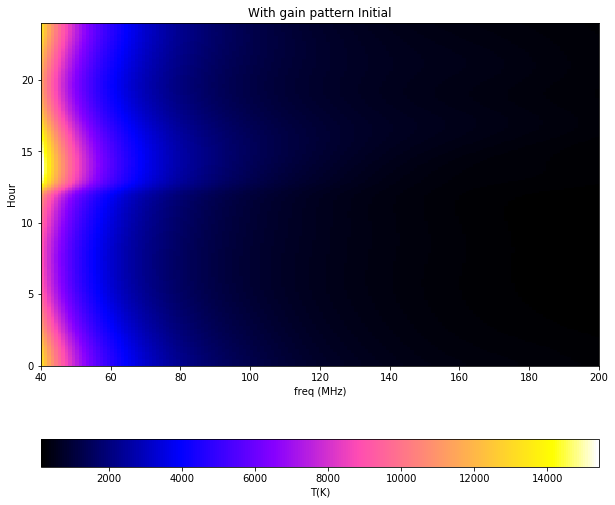

In [26]:
figure(figsize=(10,9))
horas=linspace(0,24,240)
pcolormesh(f,horas, TG_CA,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern Initial"),xlabel('freq (MHz)'),ylabel('Hour')

In [31]:
TG_I==TG_CA

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [36]:
fig1=pd.read_csv('/Users/michellemora/Documents/Universidad/9/Germanchou/figure1_plotdata.csv',names=['Freq','Weight','Tsky','Tres1','Tres2','Tmodel','T21'],skiprows=4,skipfooter=2,engine='python')
freqs1=f



([[<matplotlib.lines.Line2D at 0x13dce65f8>],
 Text(0.5,0,'freq (MHz)'),
 Text(0,0.5,'T (K)'))

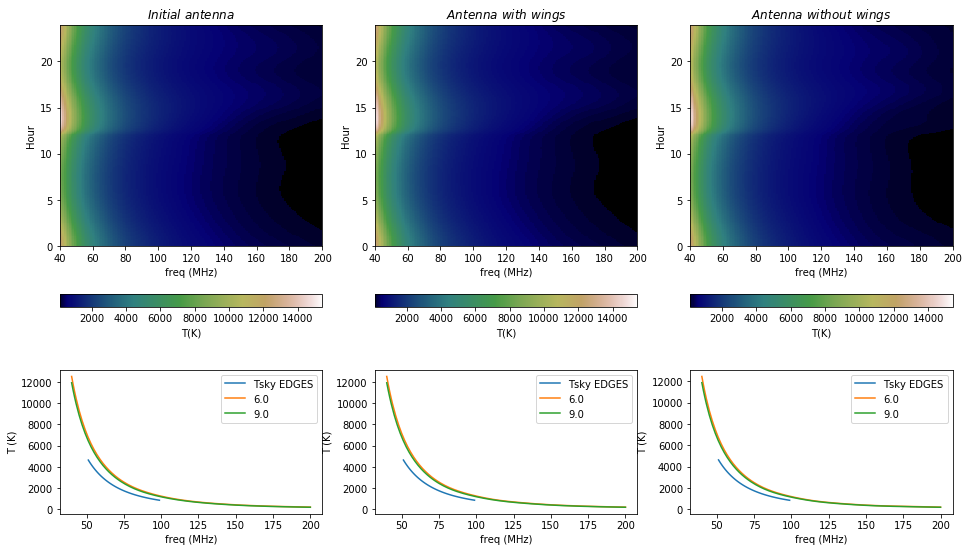

In [55]:
figure(figsize=(16,9))
subplot2grid((3,3), (0,0),rowspan=2)
pcolormesh(f,horas, TG_I,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$Initial\ antenna$"),xlabel('freq (MHz)'),ylabel('Hour')

subplot2grid((3,3), (0,1),rowspan=2)
pcolormesh(f,horas, TG_SA,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$Antenna\ with\ wings$"),ylabel('Hour'),xlabel('freq (MHz)')

subplot2grid((3,3), (0,2),rowspan=2)
pcolormesh(f,horas, TG_CA,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("$Antenna\ without\ wings$"),ylabel('Hour'),xlabel('freq (MHz)')

#GRAFICO MALO!!!! ARREGLAR HORAS DESDE PLOTS
subplot2grid((3,3), (2,0))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,TG_I[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,1))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,TG_SA[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

subplot2grid((3,3), (2,2))
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
[plot(freqs1,TG_CA[i],label=i/2) for i in ([12,18])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')

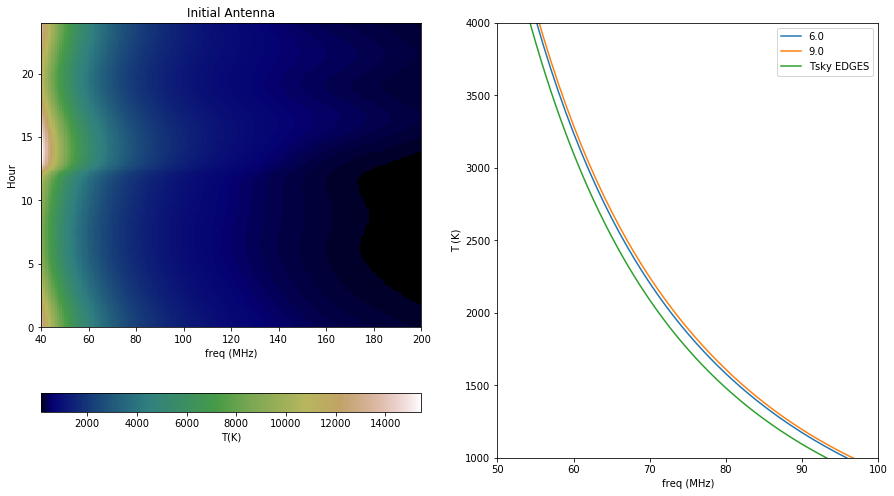

In [64]:
figure(figsize=(15,8))
subplot(1,2,1)
pcolormesh(f,horas, TG_I,cmap='gist_earth')
colorbar(label='T(K)',orientation="horizontal")
title("Initial Antenna"),ylabel('Hour'),xlabel('freq (MHz)')
subplot(1,2,2)
[plot(f,TG_I[i],label=i/10) for i in ([60,90])],legend(),xlabel('freq (MHz)'),ylabel('T (K)')
plot(fig1['Freq'],fig1['Tsky'],label='Tsky EDGES')
xlim([50,100]),ylim([1000,4000])
legend()

(Text(0.5,1,'With gain pattern Initial'),
 Text(0.5,0,'freq (MHz)'),
 Text(0,0.5,'Hour'))

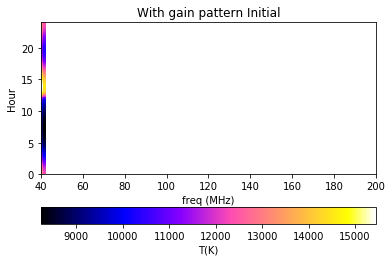

In [78]:
#figure(figsize=(16,9))
horas=linspace(0,24,240)
pcolormesh(f,horas, TG_I,cmap='gnuplot2')
colorbar(label='T(K)',orientation="horizontal")
title("With gain pattern Initial"),xlabel('freq (MHz)'),ylabel('Hour')

In [48]:
T_G_B=loadtxt('/Users/michellemora/Documents/Universidad/9/Germanchou/DS+G B.txt')
T_G_B

array([[13595.72391497, 12738.16063794, 11951.05530212, ...,
          837.8150343 ,   824.46036653,   811.59687382],
       [13736.13173691, 12869.5626884 , 12074.22674587, ...,
          846.32308922,   832.69543013,   819.56765192],
       [12706.86195801, 11907.58391851, 11173.79204259, ...,
          784.43291647,   772.5635802 ,   761.13087434],
       ...,
       [17397.17753466, 16317.82977554, 15328.33303551, ...,
         1084.84704335,  1062.00289218,  1039.84951781],
       [16028.55439481, 15023.78432263, 14102.30723175, ...,
          990.81795067,   971.73351078,   953.27393922],
       [14751.76291825, 13821.8406198 , 12968.64439289, ...,
          908.75518092,   892.90605562,   877.61717564]])

### First try (wrong)

### Dynamic Spectra with gain pattern $g=g(\theta,\phi)$

In [ ]:
def Temps_gain_final(fs,ts,alfa):  
    '''Takes frequencies (fs), times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    start = time.time()
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size): 
        
        
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     ##phi's==azimuth
        phi=phi.value.astype(int)                                 ##Int value (dphi=1deg)
        
        
        T_f=T_freq(alfa,408,fs,T_sky)             #Extrapolation
            
        gain=G_n[fs,Th,phi]/mean(G_n[fs,Th,phi])          ##Gains of Th and phi in same order as Tsky  
            
        T_f_g=gain*T_f                            #New T_sky with respective gain
        
        Temps_g[-i,:]=mean(T_f_g)                 #Mean temperature (bottom to top)
        
    end = time.time()
    print('Tiempo(min):',(end - start)/60)    
        
      
    return Temps_g

In [ ]:
T_G_NO=loadtxt('DS+G FINAL.txt')

In [ ]:
GainTotal [] - Freq='0.04GHz' Phi='0deg'

In [ ]:
def Temps_gain(fs,ts,alfa,G_n):  
    '''Takes frequencies (fs), times in AltAz frame (ts) and returns the Temperature + Gain matrix'''
    
    
    Temps_g=zeros((ts.obstime.size,len(fs))) 
    for i in range (ts.obstime.size):  
        
        start = time.time()
        aa_coord=g_coord.transform_to(ts[i])      #Galactic to Altaz
        mask=argwhere(aa_coord.alt>0)             #Only coordinates above the horizon
        T_sky=T_Hmap[mask]                        #Only those temperatures
        
        Th=np.round((90*u.deg-(aa_coord.alt[mask]))/(1*u.deg))    #Thetas to use in same order as Tsky
        Th=Th.value.astype(int)                                   #Int value (dTheta=1deg)
        
        phi=aa_coord.az[mask]                                     ##phi's==azimuth
        phi=phi.value.astype(int)                                 ##Int value (dphi=1deg)
        
        
        T_f=
        
        gain=G_n[:,Th,phi]/mean(G_n[,Th,phi])          ##Gains of Th and phi in same order as Tsky
        
        
        for j in range (len(fs)): 
            T_f=T_freq(alfa,408,fs[j],T_sky)                #Extrapolation
            
            gain=G_n[j,Th,phi]/mean(G_n[j,Th,phi])          ##Gains of Th and phi in same order as Tsky  
            
            T_f_g=gain[j]*T_f                                  #New T_sky with respective gain
            Temps_g[-i,j]=mean(T_f_g)                       #Mean temperature (bottom to top)
        
        end = time.time()
        print('Tiempo(min):',(end - start)/60)    
        
      
    return Temps_g

In [95]:
shape(Gn_I)

(161, 91, 360)

In [133]:
m=mean(Gn_I[:,[0,1],[0,1]],axis=1)   #MEAN GAIN for each frequency

In [72]:
g0 = AltAz(az=1*u.rad,alt=1*u.rad,location=Alma_loc, obstime=times6[0])
g0

<AltAz Coordinate (obstime=2021-06-14T00:00:00.000, location=(2225015.30883296, -5440016.41799762, -2481631.27428014) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (57.29577951, 57.29577951)>

In [73]:
gal_coord=g0.transform_to('galactic')

ConvertError: Cannot transform from <class 'astropy.coordinates.builtin_frames.altaz.AltAz'> to <class 'str'>